# Implementação de um contador automático de passageiros de ônibus
**Autores: Ronaldo Nunez e Vitor Lima**

**Disciplina IA898-A: Processamento digital de Imagens**

### Importando as dependências

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pims
from PIL import Image
from skimage import filters
import pandas as pd

#### Funções auxiliares

In [2]:
 def histogram(img, bins, range):
    h, be = np.histogram(img, bins=bins, range=range)
    w = range[-1]/bins
    bin_centers = be[1:]-(w/2)
    
    return bin_centers, h, w

In [3]:
def frame_analysis(frame_orig, frame_proc):
    tfig = plt.figure()

    tfig0 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
    tfig1 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
    tfig2 = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=4)
    
    tfig0.set_title('Frame original')
    tfig0.axis('off')
    tfig0.imshow(frame_orig, cmap='gray')

    tfig1.set_title('Frame subtraido')
    tfig1.axis('off')
    tfig1.imshow(frame_proc, cmap='gray')

    (bc, h , w) = histogram(frame_proc, 120, (0, 1.0))
    
    tfig2.bar(bc, h, width=w)

In [4]:
# Fonte: https://code.i-harness.com/en/q/c53fb2
def unique(array):
    uniq, index = np.unique(array, axis=0, return_index=True)
    return uniq[index.argsort()]

In [5]:
def to_gray(video):
    frames, width, hight, color = video.shape
    video_gray = np.zeros((frames, width, hight), dtype='uint32')
    
    for ii in range(len(video)):
        r, g, b = Image.fromarray(video[ii]).split()
        
        r = np.array(r, dtype='uint32')
        g = np.array(g, dtype='uint32')
        b = np.array(b, dtype='uint32')
        
        video_gray[ii] = (r + g + b) / 3
        
    return video_gray

### Abrindo os vídeos

Dataset disponível em: https://github.com/shijieS/people-counting-dataset

In [50]:
v_depth = []
v_depth.append(pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_08_48_35FrontDepth.avi'))
v_depth.append(pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_07_15_44FrontDepth.avi'))
v_depth.append(pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_19_09_56FrontDepth.avi'))
v_depth.append(pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_18_58_34FrontDepth.avi'))
v_depth.append(pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_14_37_58FrontDepth.avi'))

v_color = []
v_color.append(pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_08_48_35FrontColor.avi'))
v_color.append(pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_07_15_44FrontColor.avi'))
v_color.append(pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_19_09_56FrontColor.avi'))
v_color.append(pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_18_58_34FrontColor.avi'))
v_color.append(pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_14_37_58FrontColor.avi'))

## Método subtração de frames

![title](subt_frames.png)

Baseado no proposto em: 

Del Pizzo, Luca & Foggia, Pasquale & Greco, Antonio & Percannella, Gennaro & Vento, Mario. *A versatile and effective method for counting people on either RGB or depth image.* Itália, 2015

### Pré-processamento

O pré-processamento consiste exclusivamente em deixar o vídeo em escala de cinza.

In [7]:
X = []
for vd in v_depth:
    X.append(to_gray(np.array(vd)))

Y = []
for vc in v_color:
    Y.append(to_gray(np.array(vc)))

In [8]:
valor_real = [7, 7, 10, 13, 20]
valor_real_df = pd.DataFrame(valor_real, columns=['valor_real'])

In [9]:
I = X[0]

### Determinando o modelo de fundo

Baseado no métodos apresentados em:

Hassanpour, H. *Video Frame’s Background Modeling: Reviewing the Techniques. Journal of Signal and Information Processing*. Irã, 2011. 

#### Background Modeling Independent of Time

In [10]:
def fgmask_BMIT(video, tao):
    B_BMIT = video[0] # background model
    D_BMIT = np.abs(video - B_BMIT) # background subtraction

    # foreground mask
    F_BMIT = D_BMIT
    F_BMIT = F_BMIT / F_BMIT.max()
    F_BMIT[F_BMIT >= tao] = 1.0
    F_BMIT[F_BMIT < tao] = 0
    
    return F_BMIT

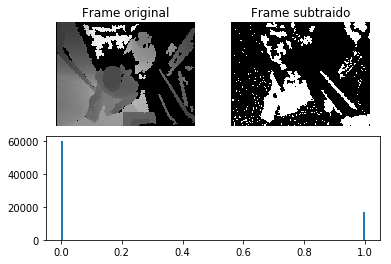

In [11]:
tao_BMIT = 0.98  # Threshold
F_BMIT = fgmask_BMIT(I, tao_BMIT)
frame_analysis(I[47], F_BMIT[47])

In [12]:
def fgmask_BMIT_otsu(video):
    B_BMIT = video[0] # background model
    D_BMIT = np.abs(video - B_BMIT) # background subtraction

    # foreground mask

    F_BMIT = D_BMIT
    F_BMIT = F_BMIT / F_BMIT.max()
    tao = filters.threshold_otsu(F_BMIT)
    F_BMIT[F_BMIT >= tao] = 1.0
    F_BMIT[F_BMIT < tao] = 0
    
    return F_BMIT

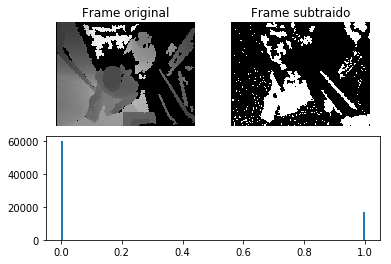

In [13]:
F_BMIT = fgmask_BMIT_otsu(I)
frame_analysis(I[47], F_BMIT[47])

####  The Long Term Average Background Modeling

In [14]:
def fgmask_LTABM(video, tao):
    # backgound model
    B_LTAMBM = np.zeros(video.shape)
    for k in range(1, len(video)):
        B_LTAMBM[k] = (1-1/k)*B_LTAMBM[k-1] + (1/k) *video[k]

    D_LTAMBM = np.abs(video - B_LTAMBM) # background subtraction

    # foreground mask
    F_LTAMBM = D_LTAMBM 
    F_LTAMBM = F_LTAMBM / F_LTAMBM.max()
    F_LTAMBM[F_LTAMBM >= tao_LTAMBM] = 1.0
    F_LTAMBM[F_LTAMBM < tao_LTAMBM] = 0
    
    return F_LTAMBM

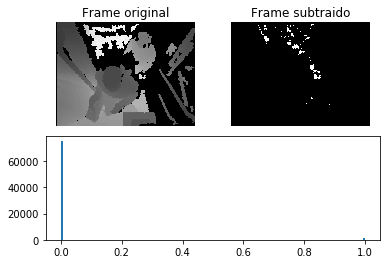

In [15]:
tao_LTAMBM = 0.2
F_LTAMBM = fgmask_LTABM(I, tao_LTAMBM)
frame_analysis(I[47], F_LTAMBM[47])

In [16]:
def fgmask_LTABM_otsu(video):
    # backgound model
    B_LTAMBM = np.zeros(video.shape)
    for k in range(1, len(video)):
        B_LTAMBM[k] = (1-1/k)*B_LTAMBM[k-1] + (1/k) *video[k]

    D_LTAMBM = np.abs(video - B_LTAMBM) # background subtraction
    # foreground mask
    F_LTAMBM = D_LTAMBM
    F_LTAMBM = F_LTAMBM / F_LTAMBM.max()
    tao = filters.threshold_otsu(F_LTAMBM)
    F_LTAMBM[F_LTAMBM >= tao] = 1.0
    F_LTAMBM[F_LTAMBM < tao] = 0
    
    return F_LTAMBM

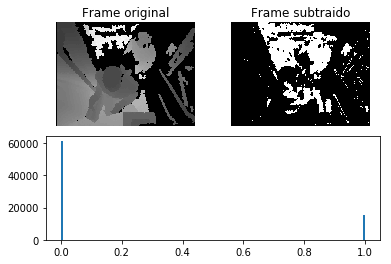

In [17]:
F_LTAMBM = fgmask_LTABM_otsu(I)
frame_analysis(I[47], F_LTAMBM[47])

#### Moving Average Backgound Modeling

In [18]:
def fgmodel_MABM(video, tao, past=10):
    # background modeling
    B_MABM = np.zeros(video.shape)
    for k in range((past-1), len(video)-1):
        B_MABM[k] = (1/past)*np.sum(video[(k-(past-1)):(k+1),:,:], axis=0)

    D_MABM = np.abs(video - B_MABM) # background subtraction

    # foreground mask
    F_MABM = D_MABM 
    F_MABM = F_MABM / F_MABM.max()
    F_MABM[F_MABM >= tao] = 1.0
    F_MABM[F_MABM < tao] = 0
    
    return F_MABM

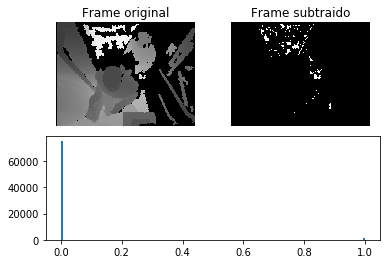

In [19]:
tao_MABM = 0.2
F_MABM = fgmodel_MABM(I, tao_MABM, 5)
frame_analysis(I[47], F_MABM[47])

In [20]:
def fgmodel_MABM_otsu(video, past=10):
    # background modeling
    B_MABM = np.zeros(video.shape)
    for k in range((past-1), len(video)-1):
        B_MABM[k] = (1/past)*np.sum(video[(k-(past-1)):(k+1),:,:], axis=0)

    D_MABM = np.abs(video - B_MABM) # background subtraction

    # foreground mask
    F_MABM = D_MABM
    F_MABM = F_MABM / F_MABM.max()
    tao = filters.threshold_otsu(F_MABM)
    F_MABM[F_MABM >= tao] = 1.0
    F_MABM[F_MABM < tao] = 0
    
    return F_MABM

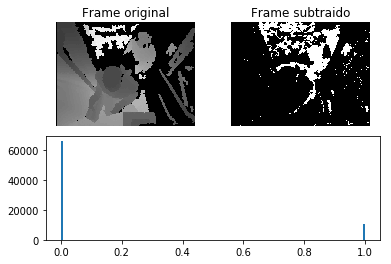

In [21]:
F_MABM = fgmodel_MABM_otsu(I, 20)
frame_analysis(I[47], F_MABM[47])

### Detecção

![title](deteccao.png)

In [22]:
def active_strips(foregd_frame, Theta, H, W, K):
    delta = W / K

    C_area = delta * H/2
    A = np.array([], dtype='uint32')

    for C_i in np.hsplit(foregd_frame, K):
        for C_j in np.vsplit(C_i, 2):
            aux = 1 if ((C_j == 1).sum() >= C_area*Theta) else 0
            A = np.append(A, aux)

    A = np.vstack((A[0::2], A[1::2]))
    
    return A

In [23]:
def active_strips_changes(fgmodel_video, Theta, H, W, K):
    A_vid = np.zeros((fgmodel_video.shape[0], 2, K))

    i = 0
    for frame in fgmodel_video:
        A_vid[i] = active_strips(frame, Theta, H, W, K)
        i += 1

    return unique(A_vid)

In [24]:
A_teste = active_strips_changes(F_LTAMBM, 0.2, I.shape[1], I.shape[2], 10)

### Contagem automática

In [25]:
def people_counter(asc_video):
    people_brd = 0
    people_unbrd = 0

    for f in range(1, asc_video.shape[0]):
        for i in range(asc_video.shape[2]):
            if ((asc_video[f-1, 0, i] == 1) and 
                (asc_video[f-1, 1, i] == 0) and
                (asc_video[f, 1, i] == 1) ):
                people_brd += 1
            
            if ((asc_video[f-1, 0, i] == 0) and 
                (asc_video[f-1, 1, i] == 1) and
                (asc_video[f, 0, i] == 1) ):
                people_unbrd += 1


    return {'boarding': people_brd, 'unboarding': people_unbrd}

In [26]:
people_counter(A_teste)

{'boarding': 34, 'unboarding': 9}

### Implementando a técnica em uma única função

In [27]:
def apcs(I, seg_threshold, det_threshold, K=10, past=5, seg_tech='MABM', dirc='boarding'):
       
    if (seg_tech == 'BMIT'):
        F_BMIT = fgmask_BMIT(I, seg_threshold)
        A_test = active_strips_changes(F_BMIT, det_threshold, I.shape[1], I.shape[2], K)
    elif(seg_tech == 'LTAMBM'):
        F_LTAMBM = fgmask_LTABM(I, seg_threshold)
        A_test = active_strips_changes(F_LTAMBM, det_threshold, I.shape[1], I.shape[2], K)
    elif(seg_tech == 'MABM'):
        F_MABM = fgmodel_MABM(I, seg_threshold, past=past)
        A_test = active_strips_changes(F_MABM, det_threshold, I.shape[1], I.shape[2], K)
    else:
        pass
    
    return people_counter(A_test)[dirc]

In [28]:
%%time
print('O numero de pessoas subindo: ', apcs(X[0], 0.12, 0.27, dirc='boarding'))

O numero de pessoas subindo:  3
CPU times: user 1.21 s, sys: 409 ms, total: 1.62 s
Wall time: 1.36 s


In [29]:
def apcs_otsu(I, det_threshold, K=10, past=5, seg_tech='MABM', dirc='boarding'):
       
    if (seg_tech == 'BMIT'):
        F_BMIT = fgmask_BMIT_otsu(I)
        A_test = active_strips_changes(F_BMIT, det_threshold, I.shape[1], I.shape[2], K)
    elif(seg_tech == 'LTAMBM'):
        F_LTAMBM = fgmask_LTABM_otsu(I)
        A_test = active_strips_changes(F_LTAMBM, det_threshold, I.shape[1], I.shape[2], K)
    elif(seg_tech == 'MABM'):
        F_MABM = fgmodel_MABM_otsu(I, past=past)
        A_test = active_strips_changes(F_MABM, det_threshold, I.shape[1], I.shape[2], K)
    else:
        pass
    
    return people_counter(A_test)[dirc]

In [30]:
%%time
print('O numero de pessoas subindo: ', apcs_otsu(X[0], 0.4, K=40, dirc='boarding'))

O numero de pessoas subindo:  3
CPU times: user 2.75 s, sys: 286 ms, total: 3.04 s
Wall time: 2.78 s


#### Estudo dos thresholds

In [31]:
seg_ths = det_ths = np.around(np.linspace(0.05, 0.95, 10), decimals=3)

results_ = []
row = 0
for i in seg_ths:
    results_.append([])
    for j in det_ths:
        results_[row].append(apcs(X[0], i, j, seg_tech='MABM', dirc='boarding'))
    row+=1

pd.DataFrame(results_, index=seg_ths, columns=det_ths)

,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95
0.05,89,67,34,4,5,1,1,1,0,0
0.15,46,2,2,1,1,0,0,0,0,0
0.25,6,1,0,0,0,0,0,0,0,0
0.35,0,0,0,0,0,0,0,0,0,0
0.45,0,0,0,0,0,0,0,0,0,0
0.55,0,0,0,0,0,0,0,0,0,0
0.65,0,0,0,0,0,0,0,0,0,0
0.75,0,0,0,0,0,0,0,0,0,0
0.85,0,0,0,0,0,0,0,0,0,0
0.95,0,0,0,0,0,0,0,0,0,0


In [32]:
seg_ths = det_ths = np.around(np.linspace(0.05, 0.95, 10), decimals=3)

results_ = []
row = 0
for i in seg_ths:
    results_.append([])
    for j in det_ths:
        results_[row].append(apcs(X[0], i, j, seg_tech='MABM', dirc='boarding'))
    row+=1

pd.DataFrame(results_, index=seg_ths, columns=det_ths)

,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95
0.05,89,67,34,4,5,1,1,1,0,0
0.15,46,2,2,1,1,0,0,0,0,0
0.25,6,1,0,0,0,0,0,0,0,0
0.35,0,0,0,0,0,0,0,0,0,0
0.45,0,0,0,0,0,0,0,0,0,0
0.55,0,0,0,0,0,0,0,0,0,0
0.65,0,0,0,0,0,0,0,0,0,0
0.75,0,0,0,0,0,0,0,0,0,0
0.85,0,0,0,0,0,0,0,0,0,0
0.95,0,0,0,0,0,0,0,0,0,0


#### Estudo do K x Threshold (área)

In [33]:
K_ar = np.array([5,10,20,40])
thresholds = np.linspace(0.05,0.95,10)
res = []
for ths in thresholds:
    for K_a in K_ar:
        res.append(apcs_otsu(X[0], ths, K=K_a, dirc='boarding'))

res_np = np.array(res).reshape((len(thresholds),len(K_ar)))
pd.DataFrame(res_np, index=thresholds, columns=K_ar)

,5,10,20,40
0.05,19,111,291,595
0.15,5,37,95,227
0.25,1,3,12,32
0.35,2,2,3,4
0.45,1,1,1,1
0.55,1,1,2,1
0.65,0,1,1,2
0.75,0,0,0,0
0.85,0,0,0,0
0.95,0,0,0,0


In [34]:
K_ar = np.array([5,10,20,40])
thresholds = np.linspace(0.05,0.15,10)
res = []
for ths in thresholds:
    res.append(apcs_otsu(X[0], ths, K=5, dirc='boarding'))

pd.DataFrame(res, index=thresholds, columns=[5])

,5
0.050000,19
0.061111,18
0.072222,16
0.083333,15
0.094444,16
0.105556,16
0.116667,14
0.127778,14
0.138889,8
0.150000,5


In [35]:
pessoas = apcs_otsu(X[0], 0.14, K=5, dirc='boarding')
print("Numero de pessoas subindo: ", pessoas)

Numero de pessoas subindo:  7


In [36]:
p = []

for file in X:
    p.append(apcs_otsu(file, 0.14, K=5, dirc='boarding'))

p_df = pd.DataFrame(p, columns=['K=5'])
p_df.join(valor_real_df)

,K=5,valor_real
0,7,7
1,7,7
2,7,10
3,18,13
4,29,20


In [ ]:
pc = []
for file in Y:
    pc.append(apcs_otsu(file, 0.14, K=5, dirc='boarding'))

pc_df = pd.DataFrame(pc, columns=['K=5'])
pc_df.join(valor_real_df)

,K=5,valor_real
0,5,7
1,1,7
2,8,10
3,7,13
4,18,20


## Método PDS

![title](pds.png)

In [44]:
def integra(x):
    s=np.sum(x,axis=1)
    s=np.sum(s,axis=1)
    return s

In [45]:
def conta_integral(x):
    x_cropped=x[:,100:240,0:125]
    integral=integra(x_cropped)
    integral=integral/np.max(integral)
    plt.figure()
    plt.plot(integral)
    limiar=np.min(integral)+((np.max(integral)-np.min(integral))/2)
    plt.plot(limiar*np.ones(integral.shape),'-r')
    info_binaria=integral<limiar
    plt.figure()
    plt.plot(info_binaria)
    picos=np.bitwise_and(info_binaria,np.invert(np.roll(info_binaria,1)))
    pessoas=np.count_nonzero(picos)
    frames_ind=np.nonzero(picos)
    return pessoas,frames_ind

In [46]:
def conta_integral_explore(x,valor_real,num):
    x_cropped=x[:,100:240,0:125]
    integral=integra(x_cropped)
    integral=integral/np.max(integral)
    ref=np.min(integral)+((np.max(integral)-np.min(integral))/2)
    limiar_list=np.arange(ref-0.15,ref+0.15,0.01)
    pessoas=np.zeros(len(limiar_list))
    for i,limiar in enumerate(limiar_list):
        info_binaria=integral<limiar
        picos=np.bitwise_and(info_binaria,np.invert(np.roll(info_binaria,1)))
        pessoas[i]=np.count_nonzero(picos)
    tx_erro=np.abs(np.subtract(pessoas,valor_real))/valor_real
    plt.figure(figsize=(8,6))
    plt.plot(limiar_list,tx_erro,'.-')
    plt.plot(limiar_list[15],tx_erro[15],'Dr')
    plt.title("Taxa de erro do vídeo %i" %num)
    
    return tx_erro

O numero de pessoas contado foi:  10
CPU times: user 52.4 ms, sys: 149 µs, total: 52.6 ms
Wall time: 51.8 ms


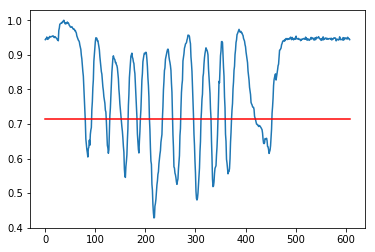

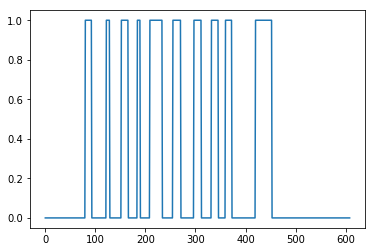

In [47]:
%%time
[pessoas,frames]=conta_integral(X[2])
print("O numero de pessoas contado foi: ",pessoas)

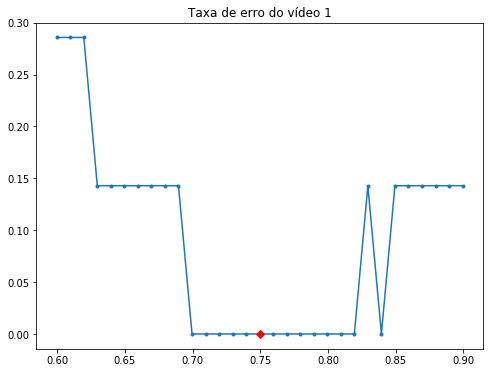

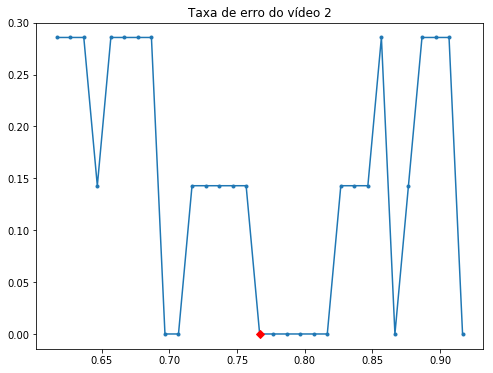

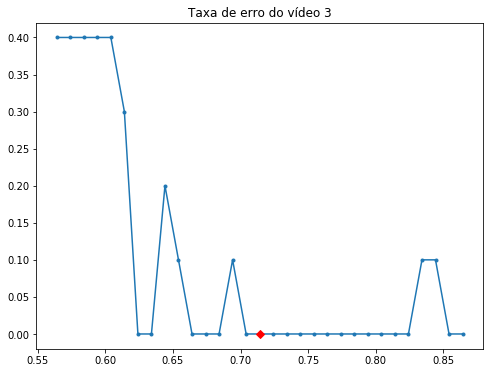

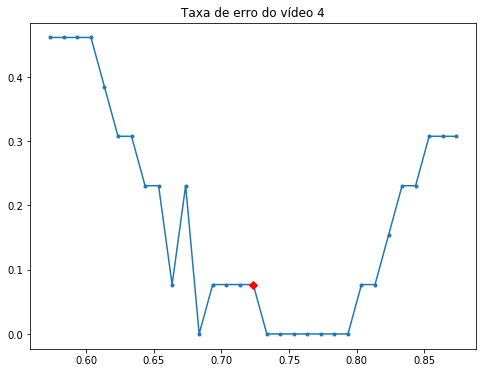

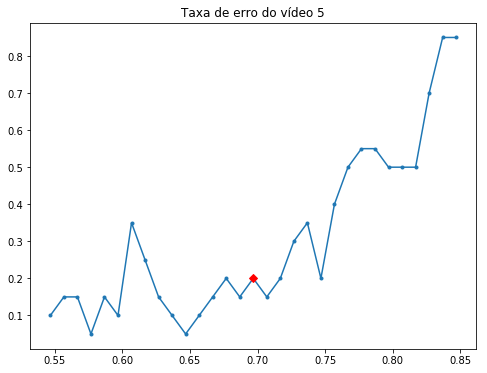

In [48]:
tx_erro=np.zeros((5,31))
for i,x in enumerate(X):
    tx_erro[i,:]=conta_integral_explore(x,valor_real[i],i+1)

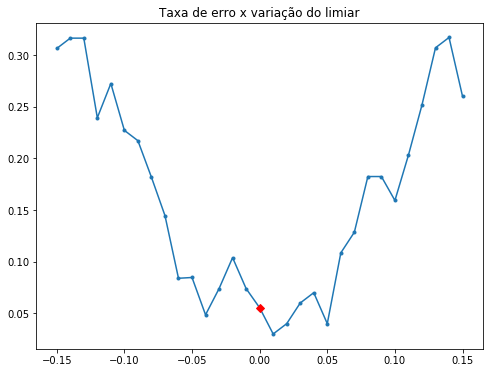

In [49]:
tx_media=np.average(tx_erro,axis=0)
var_limiar=np.arange(-0.15,0.16,0.01)
plt.figure(figsize=(8,6))
plt.title('Taxa de erro x variação do limiar')
plt.plot(var_limiar,tx_media,'.-')
plt.plot(var_limiar[15],tx_media[15],'Dr')